In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)

import tensorflow as tf

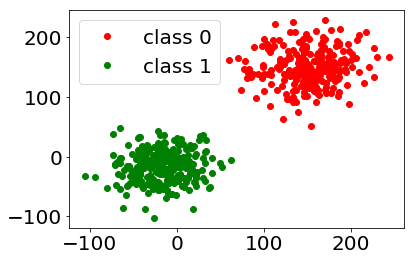

[[167.34327172 150.1958504  163.14524416]
 [-17.76546842 -25.11194467 -35.50454638]
 [187.1892412  213.17644648 145.60741357]
 [-33.40997326  17.07627547  -6.27746717]
 [183.65592147 194.34575485 144.4467741 ]]
[[0]
 [1]
 [0]
 [1]
 [0]]


In [2]:
def plot_data(X, y):
    y = y.flatten()
    
    x_point_class_0 = X[y == 0].T[0].T
    y_point_class_0 = X[y == 0].T[1].T
    
    x_point_class_1 = X[y == 1].T[0].T
    y_point_class_1 = X[y == 1].T[1].T
    
    plt.plot(x_point_class_0, y_point_class_0, 'ro', label='class 0')
    plt.plot(x_point_class_1, y_point_class_1, 'go', label='class 1')
    plt.legend()
    plt.show()

def generate_pseudo_random_data(number_of_training_points=350, n_features=2):
    # Build the Training Set
    #TODO: dynamic number of features
    number_of_training_points_per_class = int(number_of_training_points/2)

    class_0_a = 150
    class_0_b = 32

    class_1_a = -15
    class_1_b = 27
    
    X = []
    y = []

    for i in range(number_of_training_points_per_class):
        instance_class_zero = []
        for j in range(n_features):
            val = np.random.normal(class_0_a, class_0_b)
            instance_class_zero.append(val)
            
        instance_class_one = []
        for j in range(n_features):
            val = np.random.normal(class_1_a, class_1_b)
            instance_class_one.append(val)
        
        X.append(instance_class_zero)
        y.append([0])
        
        X.append(instance_class_one)
        y.append([1])


    
    return np.array(X), np.array(y)

X, y = generate_pseudo_random_data(number_of_training_points=500, n_features=3)

plot_data(X, y)

print(X[:5])
print(y[:5])

In [3]:
def build_knn_graph(number_of_training_points, number_of_features, k=3, gpu_enable=False):
    X_train = tf.placeholder(tf.float32, shape=[number_of_training_points, number_of_features],
                             name="X_train_placeholder")

    y_true = tf.placeholder(tf.float32, shape=[number_of_training_points, 1],
                            name="y_true_placeholder")

    # TODO: multiple test cases at the same time, vectorization
    X_test = tf.placeholder(tf.float32, shape=[number_of_features], name="X_test_placeholder")
    
    device = '/cpu:0'
    if gpu_enable:
        device = '/gpu:0'
        
    with tf.device(device):
        distances = tf.reduce_sum(tf.abs(tf.subtract(X_train, X_test)), axis=1)

        # we need this trick because tensorflow has top_k api and no closest_k or reverse=True api
        neg_distances = tf.multiply(distances, tf.constant(-1.0, dtype=tf.float32))

        # it returns the values and indexes from the least distant nodes
        values, indexes = tf.nn.top_k(neg_distances, k)

        if not gpu_enable:
            indexes = tf.Print(indexes, [values, indexes])

        # gathers the values using the index in the y_true tensor, it's like a multiple get
        y_pred = tf.gather(y_true, indexes)
        y_pred = tf.cast(y_pred, tf.int32)

        # aggregates sums of the values e.g. creates a tensor with the count on each index
        counts = tf.bincount(y_pred)

        if not gpu_enable:
            counts = tf.Print(counts, [counts, y_pred], message="Counts")

        # gets the index (aka corresponding class) with the max count
        with tf.device('/cpu:0'):
            class_pred = tf.argmax(counts)

    return class_pred, counts, X_train, y_true, X_test


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
number_of_training_points = 10000
n_features = 1000
test_point = [70.0]*n_features

X, y = generate_pseudo_random_data(number_of_training_points=number_of_training_points, n_features=n_features)

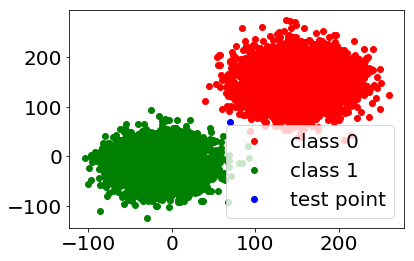

In [6]:
def plot_data_with_test_point(X, y, test_point):
    
    y = y.flatten()
    
    x_point_class_0 = X[y == 0].T[0].T
    y_point_class_0 = X[y == 0].T[1].T
    
    x_point_class_1 = X[y == 1].T[0].T
    y_point_class_1 = X[y == 1].T[1].T

    plt.plot(x_point_class_0, y_point_class_0, 'ro', label='class 0')
    plt.plot(x_point_class_1, y_point_class_1, 'go', label='class 1')
    plt.plot(test_point[0], test_point[1], 'bo', label='test point')
    plt.legend()
    plt.show()

plot_data_with_test_point(X, y, test_point)

In [7]:
import timeit
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 1000
test_runs = 1

#TF
class_pred, counts, X_train, y_true, X_test = build_knn_graph(X.shape[0], X.shape[1], k=n_neighbors, gpu_enable=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

def run_tf(class_pred, counts, X_train, y_true, X_test):
    for i in range(0, test_runs):
        test_point_pred = session.run(class_pred, feed_dict={X_train: X, y_true: y, X_test: test_point})

    print(test_point_pred)

def test_tf():
    run_tf(class_pred, counts, X_train, y_true, X_test)
############

neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(X, y)

def run_scikit_iterative():
    # iterative
    for i in range(0, test_runs):
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        neigh.fit(X, y.ravel())
        result = neigh.predict([test_point])

    print(result)

def test_scikit():
    run_scikit_iterative()
        
test_scikit()
test_tf()

if True:
    # Runs the op several times.
    print('Time (s) to knn!.')
    print('TF (s):')
    tf_time = timeit.timeit('test_tf()', number=10, setup="from __main__ import test_tf")
    print(tf_time)
    print('SCIKIT (s):')
    scikit_time = timeit.timeit('test_scikit()', number=10, setup="from __main__ import test_scikit")
    print(scikit_time)
    print('TF speedup over SCIKIT: {}x'.format(int(scikit_time/tf_time)))
    
session.close()

D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[0]
0
Time (s) to knn!.
TF (s):
0
0
0
0
0
0
0
0
0
0
0.37422971959978957
SCIKIT (s):
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
7.4203730482961365
TF speedup over SCIKIT: 19x
